## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from storesales.utils import save_submission
from storesales.advanced_predictor import AdvancedPredictor
from storesales.light_gbm.fit_evaluate.evaluate_models import evaluate
from storesales.light_gbm.utils import (
    make_submission_predictions,
    print_models_params,
    plot_feature_importance,
    load_family_lightgbm_and_dataset,
)
from storesales.constants import (
    TEST_DATE_RANGE,
    MIDDLE_TEST_DATE,
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
)

## Load && Preprocess Data

In [3]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

In [4]:
baseline_train_df = train_df.rename(columns={"date": "ds", "sales": "y"})
baseline_test_df = test_df.rename(columns={"date": "ds"})

### Load Baseline and LightGBM

In [5]:
baseline_model_file_paths = [
    "daily_predictor.pkl",
    "day_of_week_predictor.pkl",
    "weighted_day_predictor.pkl",
]
baseline_model_names = ["daily", "day_of_week", "weighted_day"]

In [6]:
families_for_lightgbm = [
    "EGGS",
    "LIQUOR,WINE,BEER",
    "MEATS",
    # ---
    "PERSONAL CARE",
    "PRODUCE",
    "SCHOOL AND OFFICE SUPPLIES",
]
dir_suffixes = ["_default_model", "", ""] + ["_default_model_mean_and_std_features"] * 3

In [7]:
lightgbm_models = {}
family_datasets = {}

for family, suffix in zip(families_for_lightgbm, dir_suffixes):
    model, family_dataset = load_family_lightgbm_and_dataset(family, dir_suffix=suffix)
    lightgbm_models[family] = model
    family_datasets[family] = family_dataset

## Evaluate && Make Submission Prediction


In [8]:
eval_family_losses = evaluate(
    dataset=family_datasets,
    evaluate_range=TEST_DATE_RANGE,
    models=lightgbm_models,
    stride=1,
    n_jobs=2,
)

100%|██████████| 6/6 [02:11<00:00, 21.96s/it]


In [9]:
lightgbm_prediction_df = make_submission_predictions(
    family_datasets=family_datasets, models=lightgbm_models
)

100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


In [ ]:
advanced_predictor = AdvancedPredictor(
    loss_split_date_str=MIDDLE_TEST_DATE,
    baseline_model_names=baseline_model_names,
    baseline_model_file_paths=baseline_model_file_paths,
    baseline_train_df=baseline_train_df,
    baseline_test_df=baseline_test_df,
    lightgbm_model_loss_df=eval_family_losses,
    lightgbm_model_prediction_df=lightgbm_prediction_df.reset_index(),
)

## Plot Result

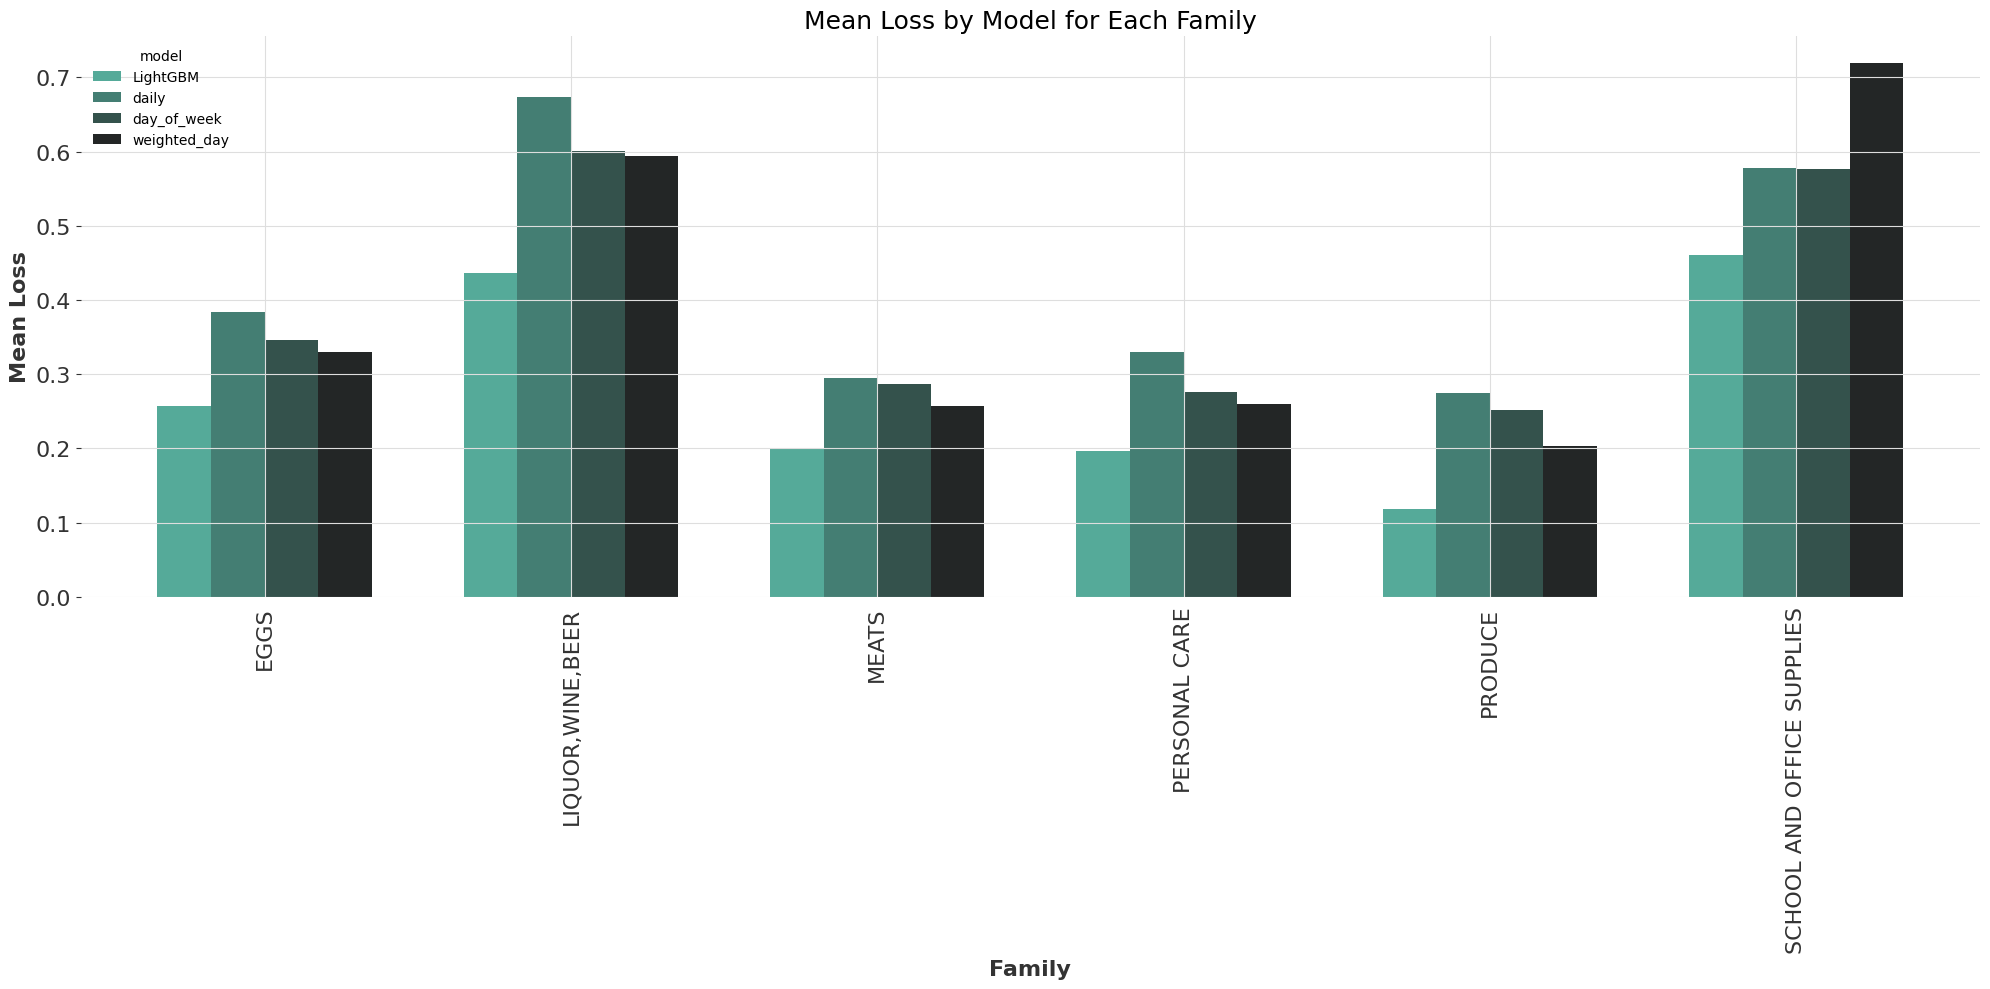

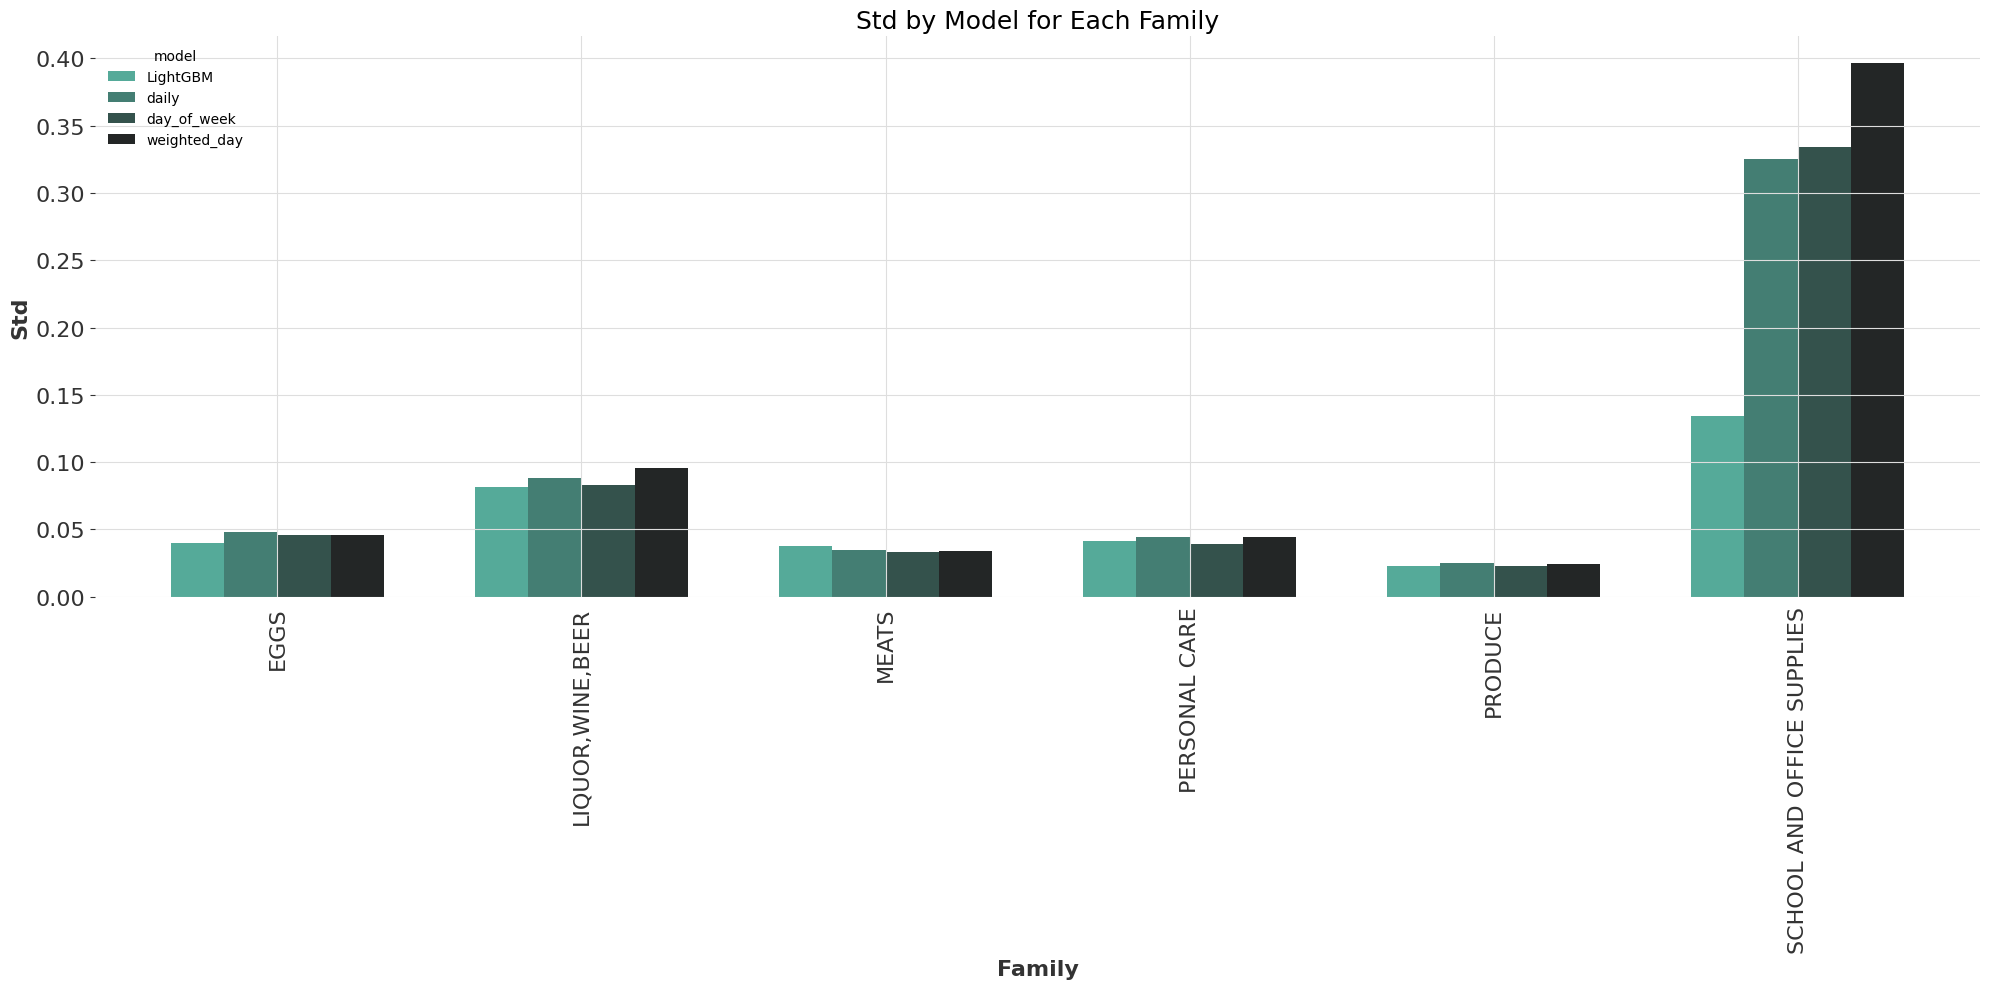

In [60]:
advanced_predictor.make_overall_family_loss_plot(
    families=families_for_lightgbm, test_loss=True
)

# advanced_predictor.make_overall_family_loss_plot(
#     families=families_for_lightgbm,
#     test_loss=True
# )

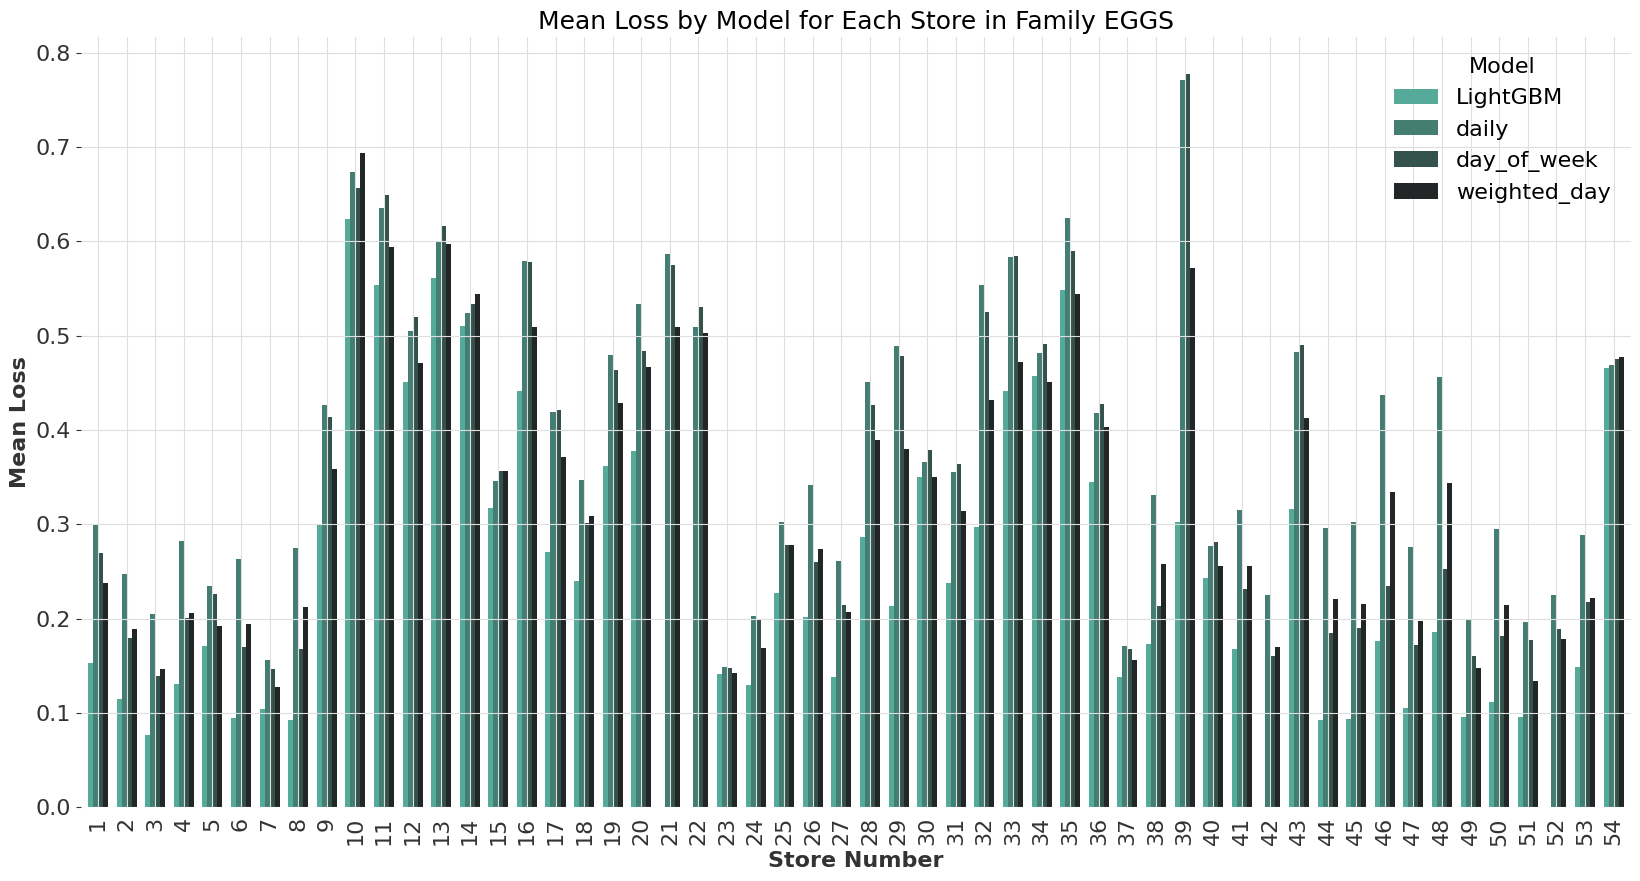

<Figure size 640x480 with 0 Axes>

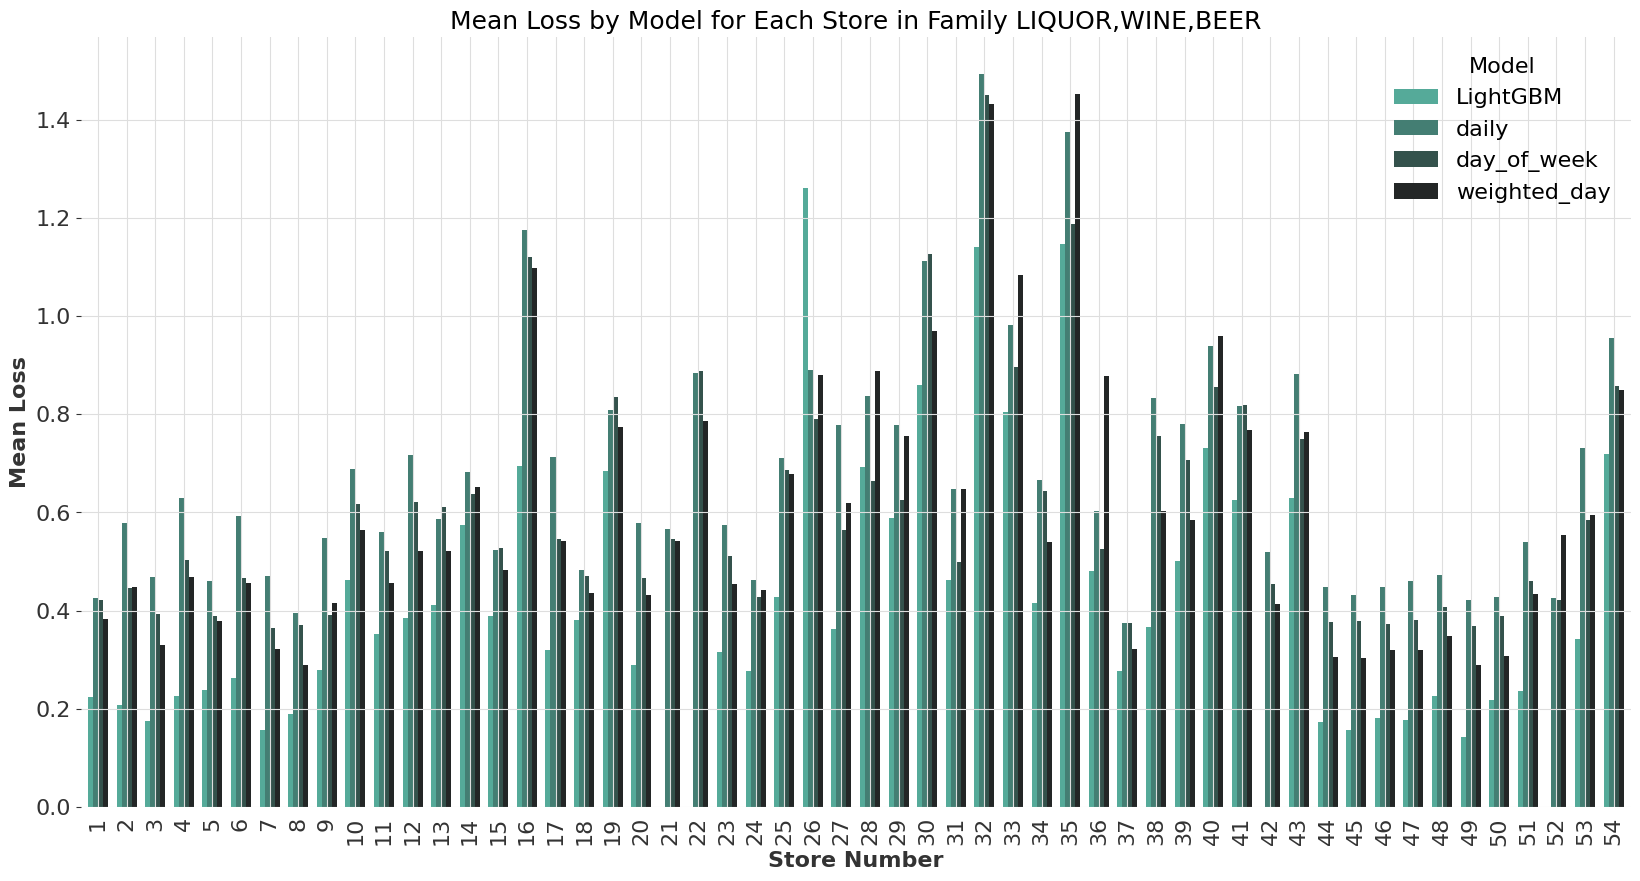

<Figure size 640x480 with 0 Axes>

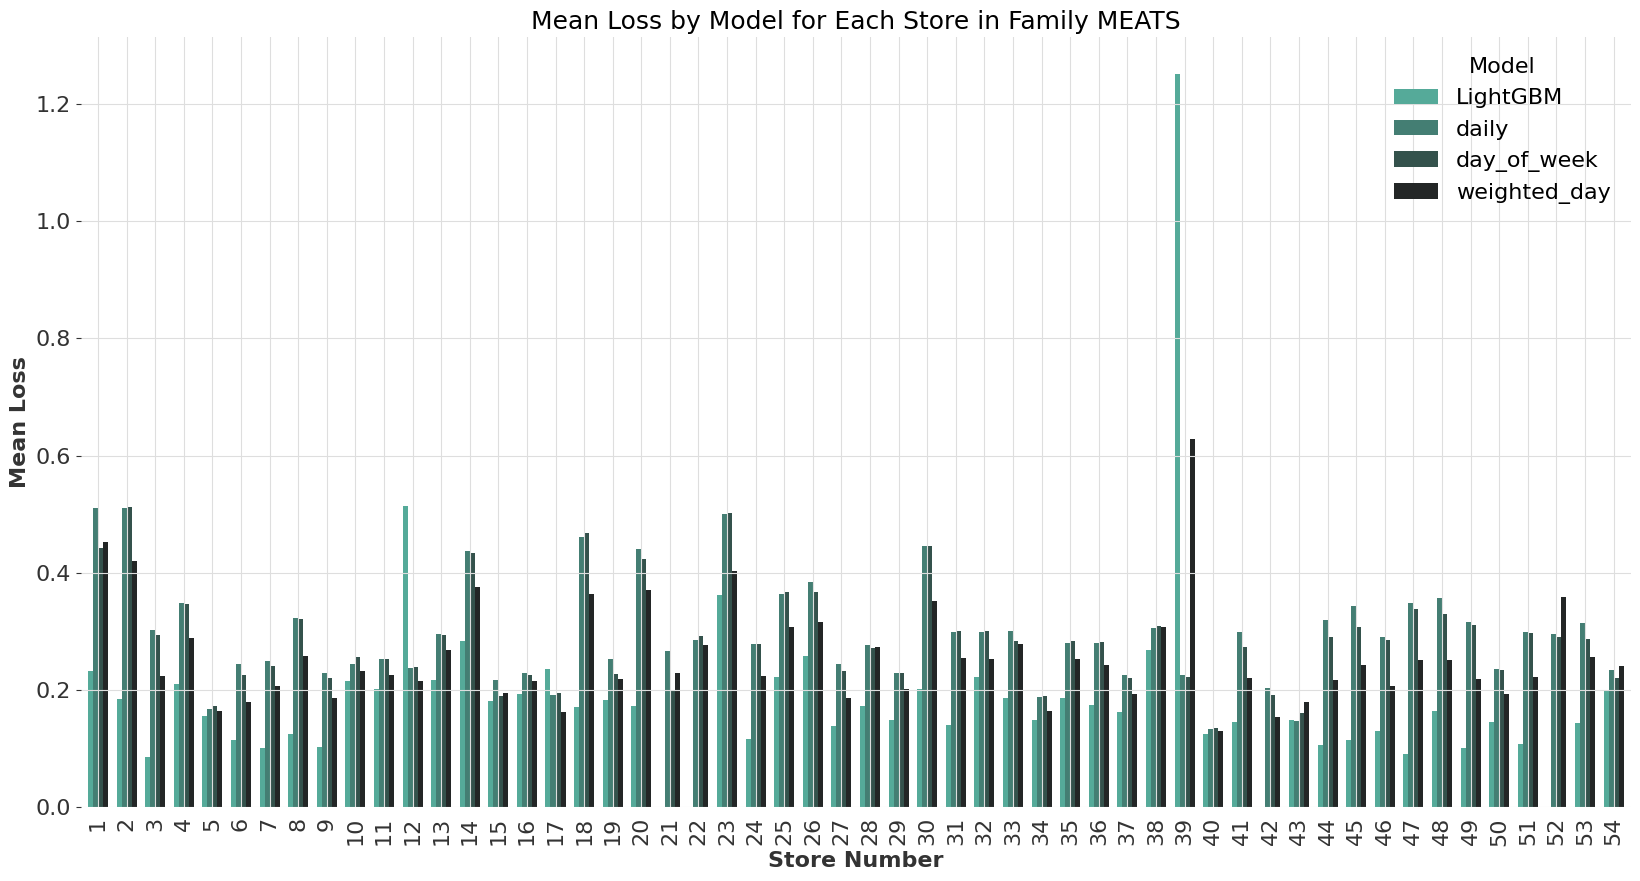

<Figure size 640x480 with 0 Axes>

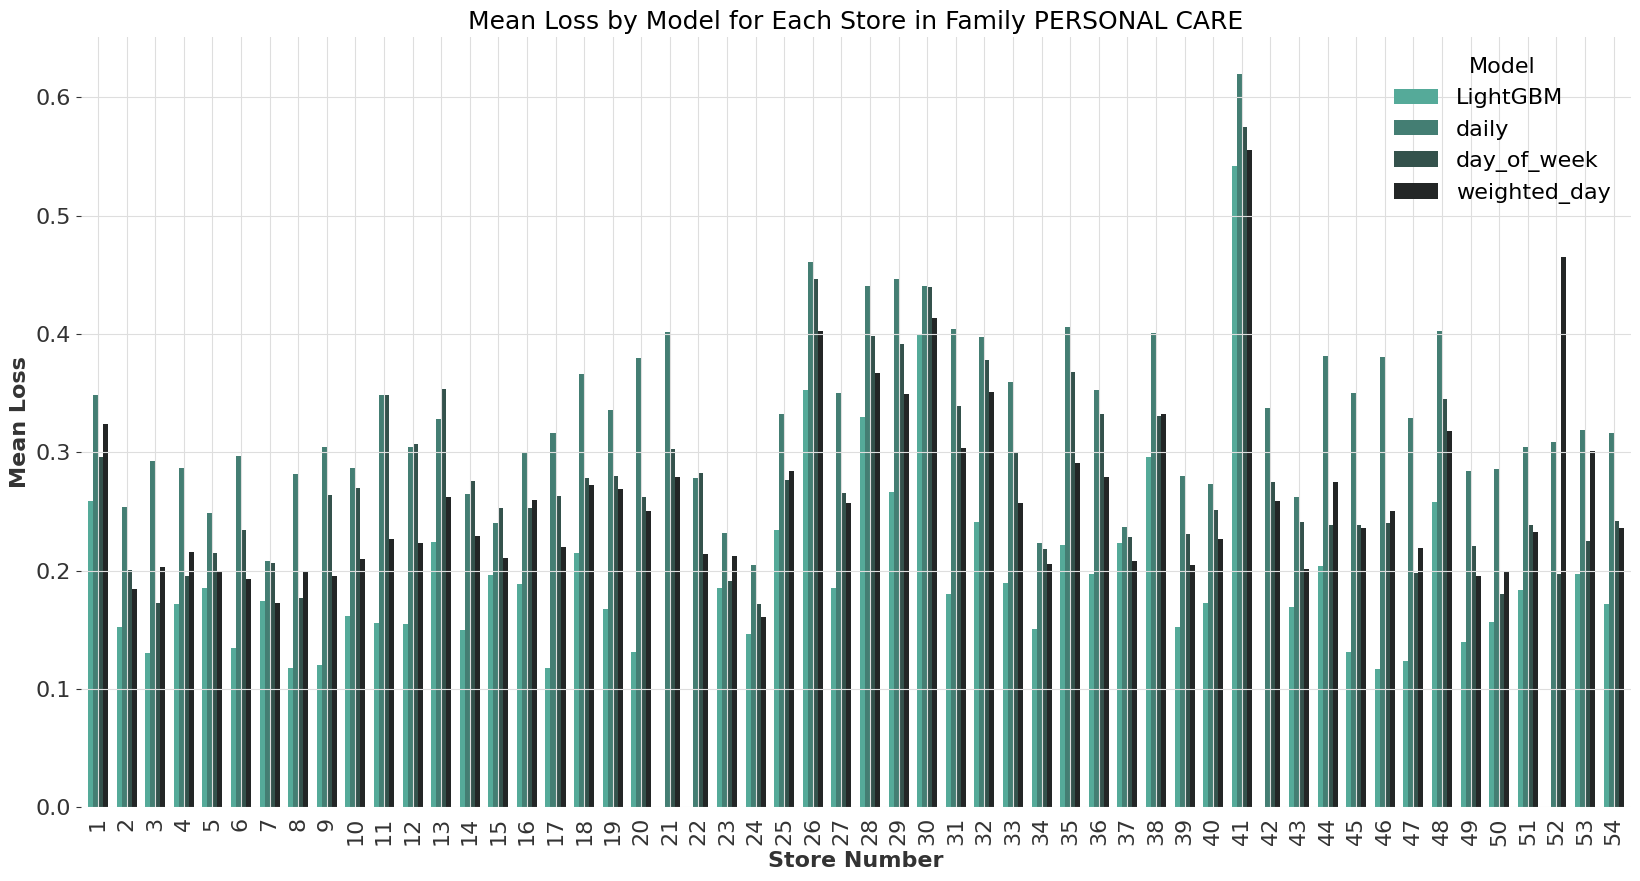

<Figure size 640x480 with 0 Axes>

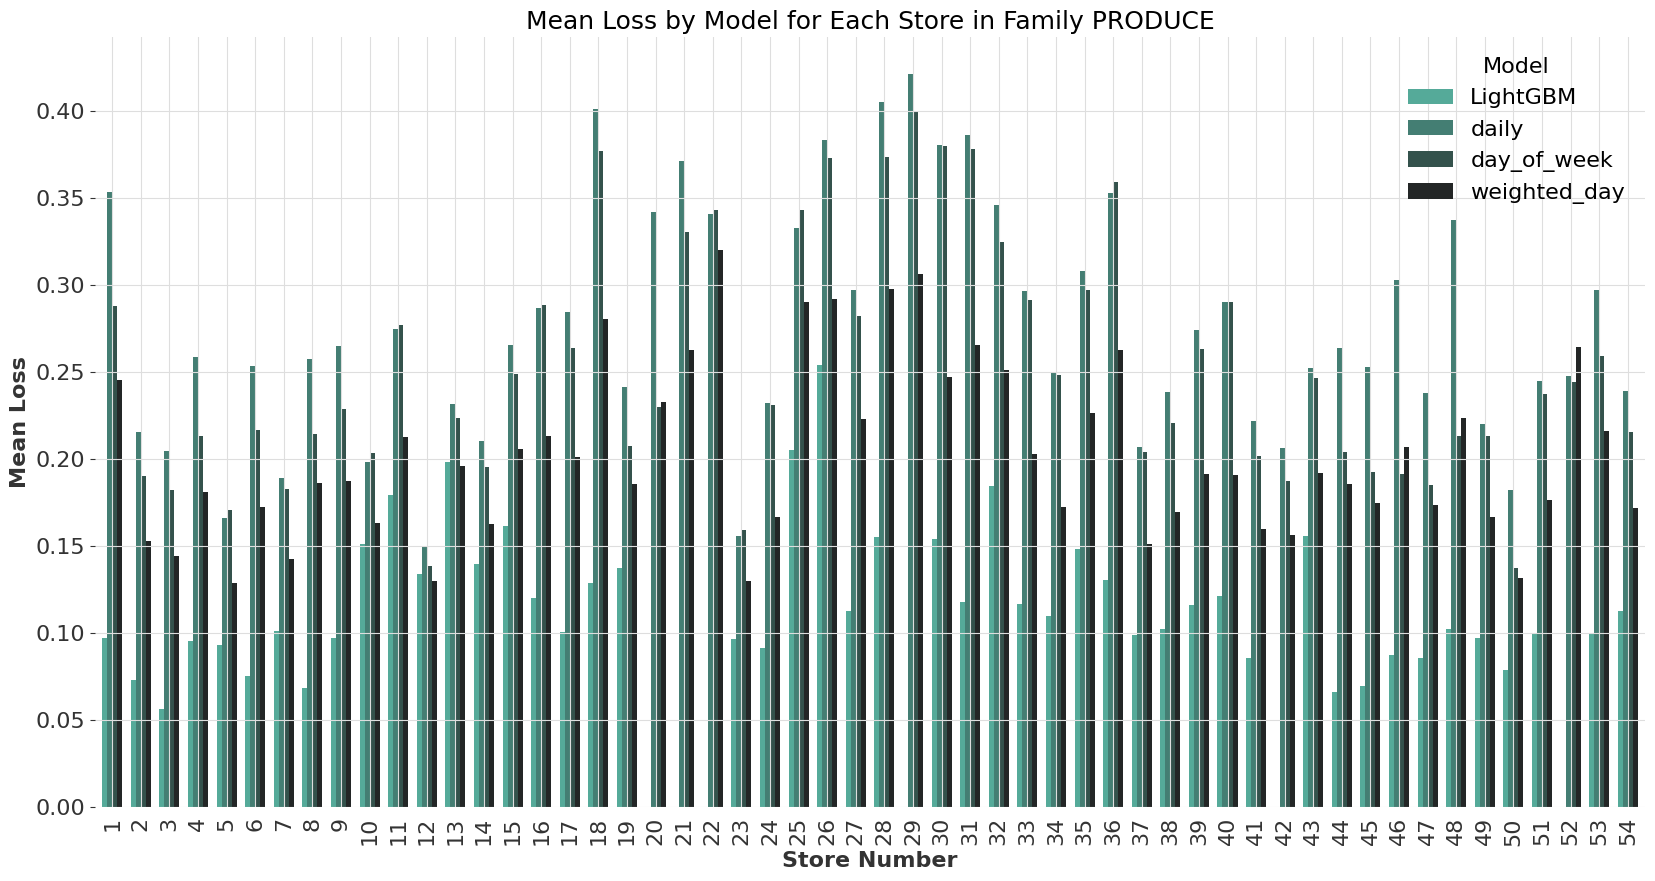

<Figure size 640x480 with 0 Axes>

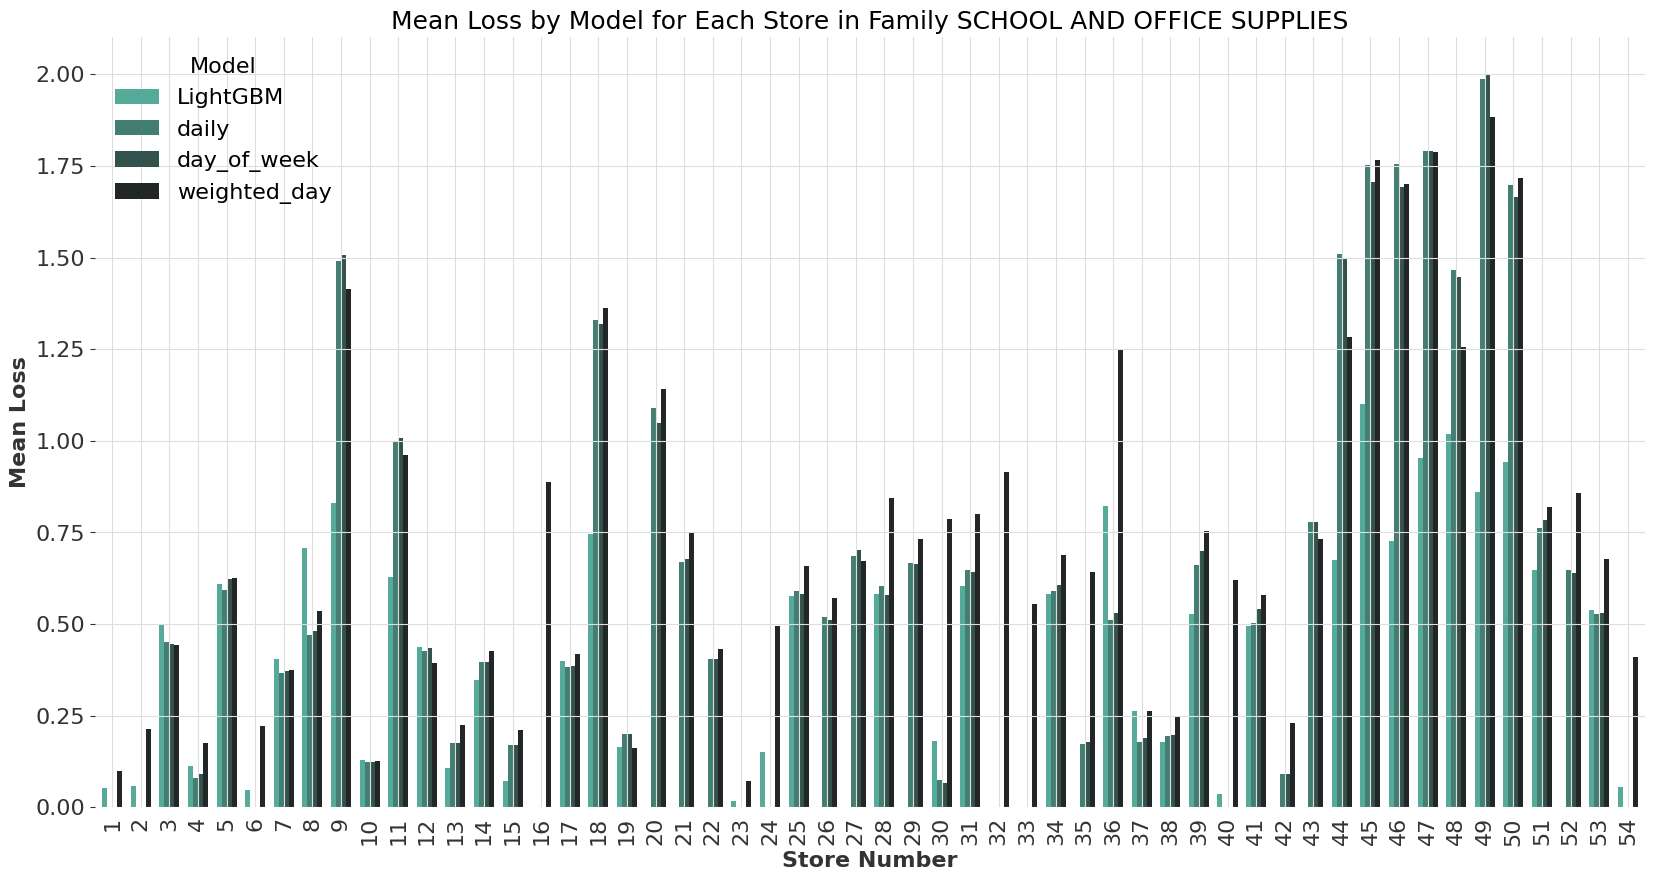

<Figure size 640x480 with 0 Axes>

In [18]:
for family in families_for_lightgbm:
    advanced_predictor.make_family_loss_plot(family=family, test_loss=True)

## Get Optimal Prediction
### Each Store Strategy

In [102]:
optimal_prediction_no_std = advanced_predictor.get_optimal_prediction(
    strategy="each_store"
)
family_mean_loss_no_std = advanced_predictor.calc_mean_loss(
    optimal_prediction_no_std.index
)

print(f"Mean Loss: {family_mean_loss_no_std.mean()}")

Mean Loss: 0.3553323300458746


### Mean Family Strategy

In [103]:
optimal_prediction_no_std = advanced_predictor.get_optimal_prediction(
    strategy="mean_family"
)
family_mean_loss_no_std = advanced_predictor.calc_mean_loss(
    optimal_prediction_no_std.index
)

print(f"Mean Loss: {family_mean_loss_no_std.mean()}")

Mean Loss: 0.35599079960269436


### Combined Strategy

In [104]:
optimal_prediction_no_std = advanced_predictor.get_optimal_prediction(
    strategy="combined"
)
family_mean_loss_no_std = advanced_predictor.calc_mean_loss(
    optimal_prediction_no_std.index
)

print(f"Mean Loss: {family_mean_loss_no_std.mean()}")

Mean Loss: 0.35266558700251005
